In [1]:
import numpy as np
import scipy.integrate as integrate
import pydelfi.ndes as ndes
from pydelfi import delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
import h5py
import tqdm
from astropy.cosmology import Planck15, z_at_value, FlatwCDM
import astropy.units as u
from scipy.integrate import cumtrapz
from scipy.interpolate import RectBivariateSpline, interp1d
from true_params import true_params, uncert, ifo
tf.logging.set_verbosity(tf.logging.ERROR)
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [2]:
with h5py.File('/Users/hyraland/Projects/GW/Cosmology/PISNLineCosmography/thetas.h5', 'r') as f:
    thetas = np.array(f['Theta'])
thetas = np.sort(np.concatenate((thetas, [0,1])))
ticum = interp1d(np.linspace(0, 1, len(thetas)), thetas)

with h5py.File('/Users/hyraland/Projects/GW/Cosmology/PISNLineCosmography/optimal_snr.h5', 'r') as f:
    ms = np.array(f['ms'])
    rhos = np.array(f['SNR'])
oint = RectBivariateSpline(ms, ms, rhos)

In [3]:
def optimal_snr(m1obs, m2obs, dl):
    return oint.ev(m1obs, m2obs)/dl

zMax = 2 # determined based on making sure the observed redshift distribution tails off completely
z = np.expm1(np.linspace(np.log(1), np.log(zMax+1), 1000))

def event(h0, omegam, om, z):
# # Use this for parameter dependent distribution
    cosm = FlatwCDM(h0, omegam, om)
    dNdz = 4.0*np.pi*true_params['R0']*(1+z)**(true_params['gamma']-1)*cosm.differential_comoving_volume(z).to(u.Gpc**3/u.sr).value

    Nperyear = np.trapz(dNdz, z)
    Nz = cumtrapz(dNdz, z, initial=0)

    z_icdf = interp1d(Nz/Nperyear, z)

    return Nperyear, Nz, z_icdf

mmin = true_params['MMin']
mmax = true_params['MMax']

def draw_pl(x0, x1, alpha, N):
    r = np.random.rand(N)
    opa = 1+alpha
    return (x0**opa*(1-r) + x1**opa*r)**(1/opa)
# def draw_pl(x0, x1, alpha):
#     r = np.random.rand()
#     opa = 1+alpha
#     return (x0**opa*(1-r) + x1**opa*r)**(1/opa)

def draw_truth(z_icdf, N):
    m2 = np.linspace(1.0,1.0,N)
    m1 = np.linspace(0.0,0.0,N)
    while np.any(m2 > m1):
        sel = m2 > m1
        m1[sel] = draw_pl(mmin,mmax,-true_params['alpha'],len(m1[sel]))
        m2[sel] = draw_pl(mmin,mmax,true_params['beta'],len(m2[sel]))

#     for i in range(N):
#         while m2[i] >= m1[i]:
#             m1[i] = draw_pl(mmin,mmax,-true_params['alpha'])
#             m2[i] = draw_pl(mmin,mmax,true_params['beta'])
    z = z_icdf(np.random.rand(N))
    t = ticum(np.random.rand(N))
    
    return (m1, m2, z, t)

def draw_truth_sim(z_icdf, N, alpha, beta):
    m2 = np.linspace(1.0,1.0,N)
    m1 = np.linspace(0.0,0.0,N)
    #print('draw truth for start')
    while np.any(m2 > m1):
        sel = m2 > m1
        m1[sel] = draw_pl(mmin,mmax,-alpha,len(m1[sel]))
        m2[sel] = draw_pl(mmin,mmax,beta,len(m2[sel]))

#     for i in range(N):
#         while m2[i] >= m1[i]:
#             m1[i] = draw_pl(mmin,mmax,-true_params['alpha'])
#             m2[i] = draw_pl(mmin,mmax,true_params['beta'])
    #print('draw truth for end')
    z = z_icdf(np.random.rand(N))
    t = ticum(np.random.rand(N))
    
    return (m1, m2, z, t)

def dl_from_rho(tobs, rhoobs, m1obs, m2obs):
    return tobs*oint.ev(m1obs, m2obs)/rhoobs


def observe(h0, omegam, om, m1, m2, z, t, N0):
    #print('observe using N0')
    cosm = FlatwCDM(h0, omegam, om)
    m1obs = m1*(1+z)
    m2obs = m2*(1+z)
    z0 = np.expm1(np.linspace(np.log(1), np.log(3), 1000))
    d = cosm.luminosity_distance(z0).to(u.Gpc).value
    d_of_z = interp1d(z0, d)
    dl = d_of_z(z) # cosm.luminosity_distance(z).to(u.Gpc).value
    rho = optimal_snr(m1obs, m2obs, dl)*t
    
    rho_obs = rho + np.random.randn(N0)
    
#     dldrawns = dl_from_rho(t, rho_obs, m1obs, m2obs)
#     dldrawn = dl_from_rho(t, rho, m1obs, m2obs)

#     plt.hist(dldrawns, 30,(-1,30), facecolor='green', alpha=0.5)
#     plt.title('dl draw from rho_obs(no selection)')
#     plt.xlim(-1,30)
#     plt.show()
 
    
#     plt.hist(dldrawn, 30,(-1,30), facecolor='green', alpha=0.5)
#     plt.title('dl draw from rho(no selection)')
#     plt.xlim(-1,30)
#     plt.show()

#     plt.hist(dl, 30,(-1,30), facecolor='green', alpha=0.5)
#     plt.title('dl draw from dist of z(no selection)')
#     plt.xlim(-1,30)
#     plt.show()
    
#     plt.hist(rho, 30, facecolor='red', alpha=0.5)
#     plt.title('rho(no selection)')
#     plt.show()

#     plt.hist(rho_obs, 30, facecolor='red', alpha=0.5)
#     plt.title('rho_obs(no selection)')
#     plt.show()
    
    
    sel = rho_obs > 8
    #print('observe using N0 over')
    m1obs = m1obs[sel]
    m2obs = m2obs[sel]
    dl = dl[sel]
    rho_obs = rho_obs[sel]
    # dldrawns = dldrawns[sel]
    ttrue = t[sel]
    
    mt = m1obs+m2obs
    eta = m1obs*m2obs/(mt*mt)
    mc = mt*eta**(3.0/5.0)
    N = len(dl)

    smc = abs(uncert['threshold_snr']/rho_obs*uncert['mc'])    
    mcobs = np.random.lognormal(mean=np.log(mc), sigma=smc)
    
    seta = uncert['threshold_snr']/rho_obs*uncert['eta']
    etaobs = np.linspace(1,1,N)
    for i in range(N):
        while (etaobs[i] < 0) or (etaobs[i] > 0.25):
            etaobs[i] = eta[i] + seta[i]*np.random.randn()
        
    st = uncert['threshold_snr']/rho_obs*uncert['Theta']
    tobs = np.linspace(2,2,N)
    
    for i in range(N):
        while (tobs[i] < 0) or (tobs[i] > 1):
            tobs[i] = ttrue[i] + st[i]*np.random.randn()
    
#     dldraw = dl_from_rho(tobs, rho_obs, m1obs, m2obs)

#     plt.hist(rho_obs, 30, facecolor='red', alpha=0.5)
#     plt.title('rho_obs(with selection)')
#     plt.show()

#     plt.hist(dl, 30, facecolor='blue', alpha=0.5)
#     plt.title('dl draw from dist of z(selected)')
#     plt.show()
    
#     plt.hist(dldrawns, 30, facecolor='green', alpha=0.5)
#     plt.title('dl draw from rho_obs and then select(selected)')
#     plt.show()

#     plt.hist(dldraw, 30, facecolor='blue', alpha=0.5)
#     plt.title('dl draw from selected rho_obs(selected)')
#     plt.show()
    
#     rhodraw = optimal_snr(m1obs, m2obs, dldraw)*tobs

#     plt.hist(rhodraw, 30, facecolor='red', alpha=0.5)
#     plt.title('rho_obs draw from dldraw(with selection)')
#     plt.show()
        
    return ((mcobs, etaobs, rho_obs, tobs, dl), (smc, seta, 1.0, st))

def mc_eta_from_m1m2(m1, m2):
    mt = m1+m2
    eta = m1*m2/(mt*mt)
    mc = mt*eta**(0.6)
    return mc, eta
def m1m2_from_mc_eta(mc, eta):
    mt = mc/eta**(0.6)
    
    disc = 1-4*eta
    sd = np.sqrt(disc)
    m1 = 0.5*mt*(1+sd)
    m2 = 0.5*mt*(1-sd)
    return m1, m2


In [4]:
def cd(n, d):
    d = array(d)
    out.create_dataset(n, data=d, compression='gzip', shuffle=True)

def get_obsdata(h0, omegam, om, Nperyear, z_icdf, seed):
    
    old_state = np.random.get_state()
    np.random.seed(seed)

    Nsmall_tot = np.random.poisson(Nperyear/12.0) # One month
    N1yr_tot = Nsmall_tot + np.random.poisson(Nperyear*(1-1/12.0)) # One year
    N5yr_tot = N1yr_tot + np.random.poisson(Nperyear*4) # Five years

    m1s, m2s, zs, thetas = draw_truth(z_icdf, N1yr_tot)

    (mcobs, etaobs, rhoobs, tobs), (smc, seta, srh, st) = observe(h0, omegam, om, m1s, m2s, zs, thetas, N1yr_tot)

    return (mcobs, etaobs, rhoobs, tobs)

def get_obsdata_sim(h0, omegam, om, alpha, beta, Nperyear, z_icdf, seed):
    
    old_state = np.random.get_state()
    np.random.seed(seed)

    Nsmall_tot = np.random.poisson(Nperyear/12.0) # One month
    N1yr_tot = Nsmall_tot + np.random.poisson(Nperyear*(1-1/12.0)) # One year
    N5yr_tot = N1yr_tot + np.random.poisson(Nperyear*4) # Five years
    m1s, m2s, zs, thetas = draw_truth_sim(z_icdf, N1yr_tot, alpha, beta)
    (mcobs, etaobs, rhoobs, tobs, dltrue), (smc, seta, srh, st) = observe(h0, omegam, om, m1s, m2s, zs, thetas, N1yr_tot)

#     sel = rhoobs > 8

#     zs = zs[sel]
#     thetas = thetas[sel]
#     m1s = m1s[sel]
#     m2s = m2s[sel]
#     mcobs = mcobs[sel]
#     etaobs = etaobs[sel]
#     rhoobs = rhoobs[sel]
#     tobs = tobs[sel]

    return (mcobs, etaobs, rhoobs, tobs, dltrue)

In [5]:
# different way of binning data from LFI_pisn_model

def bin_data(nbin, dl, m1, dlrange):

    m90 = np.linspace(0, 0, nbin)
    m50 = np.linspace(0, 0, nbin)
    m90_dl = np.linspace(0, 0, nbin)

    for j in range(nbin):
        #m90_dl[j] = 0.5*(dlrange[j]+dlrange[j+1])
        m90_temp = []
        m50_temp = []
        m90_back = []
        dl90_temp = []
        for i in range(len(dl[:])):
            dl_t = dl[i]  
            if dl_t > dlrange[j] and dl_t < dlrange[j+1]:
                m90_temp.append(m1[i])
                m50_temp.append(m1[i])
                m90_back.append(m1[i])
                dl90_temp.append(dl_t)
        ind90 = int(len(m90_temp)*0.9)
        #print(j, ind90, len(m90_temp))
        if len(m90_temp)*0.9 < 1:
            ind90 = 0

        m90t = (np.sort(np.asarray(m90_temp))[ind90])
        dlind = np.where(m90_back == m90t)
        dl90t = np.asarray(dl90_temp)[dlind]
        m90_dl[j] = dl90t #np.mean(dl90_temp)
        m90[j] = m90t
        m50[j] = np.mean(m50_temp)
    
    return m90, m50, m90_dl
    #return m1, dl
    
def bin_data_equinum(nbin, dl, m1):
    nsample = len(m1)+0.0
    nperbin = int(nsample/(nbin))
    count = 0
    
    dlrange = np.linspace(0, 0, nbin+1)

    m90 = np.linspace(0, 0, nbin)
    m50 = np.linspace(0, 0, nbin)
    m90_dl = np.linspace(0, 0, nbin)

    pairdlm = sorted(zip(dl, m1))
    m1sort = [x1 for _,x1 in pairdlm]
    dlsort = [x2 for x2,_ in pairdlm]
    dlrange[-1] = dlsort[-1]
    for j in range(nbin):
        m90_temp = []
        m50_temp = []
        m90_back = []
        dl90_temp = []
        for i in range(nperbin): 
            m90_temp.append(m1sort[i+count*nperbin])
            m50_temp.append(m1sort[i+count*nperbin])
            m90_back.append(m1sort[i+count*nperbin])
            dl90_temp.append(dlsort[i+count*nperbin])
        ind90 = int(len(m90_temp)*0.9)
        #print(j, ind90, len(m90_temp))
        if len(m90_temp)*0.9 < 1:
            ind90 = 0
        m90t = (np.sort(np.asarray(m90_temp))[ind90])
        dlind = np.where(m90_back == m90t)
        dl90t = np.asarray(dl90_temp)[dlind]
        m90_dl[j] =  dl90t # np.mean(dl90_temp)
        m90[j] = m90t
        m50[j] = np.mean(m50_temp)
        dlrange[j] = dlsort[count*nperbin]
        count += 1
    
    return m90, m50, m90_dl, dlrange
    

In [6]:
class PISN_Model():

    def __init__(self, pisn_data_path = '/Users/hyraland/Projects/GW/Cosmology/PISNLineCosmography/'):

        # Import data
        self.theta_fiducial = np.array([Planck15.H0.value, Planck15.Om0, -1.0, true_params['alpha'], true_params['beta']])
        Nperyear, Nz, z_icdf = event(self.theta_fiducial[0], self.theta_fiducial[1], self.theta_fiducial[2], z)

        mcobs, etaobs, rhoobs, tobs, dltrue = get_obsdata_sim(self.theta_fiducial[0], self.theta_fiducial[1], self.theta_fiducial[2], self.theta_fiducial[3], self.theta_fiducial[4], Nperyear, z_icdf, 0) #np.random.randint(1<<32))
        mcobs = np.asarray(mcobs)
        etaobs = np.asarray(etaobs)
        rhoobs = np.asarray(rhoobs)
        tobs = np.asarray(tobs)
        self.nbin = 10
        m1s, m2s = m1m2_from_mc_eta(mcobs, etaobs)
        dls = dl_from_rho(tobs, rhoobs, m1s, m2s)
        
#         plt.scatter(dls, m1s, alpha=0.1)
#         plt.show()
#         plt.hist(dls, 30, alpha=0.5)
#         plt.show()
        
        m90obs, m50obs, m90_dl, dlran = bin_data_equinum(self.nbin, dls, m1s)

        self.dlrange = dlran
        self.data = np.concatenate([m90obs, m50obs])
        self.aldata = m90_dl #np.concatenate([m90_dl, m50_dl])
        # parameter sequences: h0, omegam, w, m90
        self.npar = 3

        # N data points
        self.ndata = len(m90obs)

    # Generate realisation of \mu
    def simulation(self, theta, seed):
        
        Nperyear, Nz, z_icdf = event(theta[0], theta[1], theta[2], z)

        mcobs, etaobs, rhoobs, tobs, dltrue = get_obsdata_sim(theta[0], theta[1], theta[2], theta[3], theta[4], Nperyear, z_icdf, seed)

        mcobs = np.asarray(mcobs)
        etaobs = np.asarray(etaobs)
        rhoobs = np.asarray(rhoobs)
        tobs = np.asarray(tobs)

        m1s, m2s = m1m2_from_mc_eta(mcobs, etaobs)
        dls = dl_from_rho(tobs, rhoobs, m1s, m2s)

        m90obs, m50obs, m90_dl = bin_data(self.nbin, dls, m1s, self.dlrange)

        return np.concatenate([m90obs, m50obs])

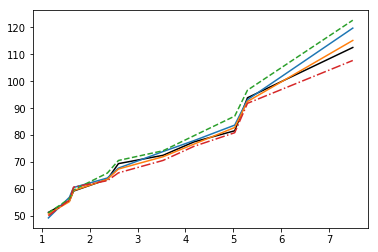

In [7]:
PISNSimulator = PISN_Model()

def simulator(theta, seed, simulator_args, batch):
    
    return PISNSimulator.simulation(theta, seed)

simulator_args = None

theta_fiducial = np.array([Planck15.H0.value, Planck15.Om0, -1.0, true_params['alpha'], true_params['beta']])
plt.plot(PISNSimulator.aldata, PISNSimulator.data[0:PISNSimulator.nbin], '-k')

s = np.random.randint(1<<32)
plt.plot(PISNSimulator.aldata, simulator(theta_fiducial, s, None, 1)[0:PISNSimulator.nbin])
s = np.random.randint(1<<32)
plt.plot(PISNSimulator.aldata, simulator(theta_fiducial, s, None, 1)[0:PISNSimulator.nbin])
plt.plot(PISNSimulator.aldata, simulator(theta_fiducial+np.array([0,0,0.5,0,0]), s, None, 1)[0:PISNSimulator.nbin], '--')
plt.plot(PISNSimulator.aldata, simulator(theta_fiducial+np.array([0,0,-0.5,0,0]), s, None, 1)[0:PISNSimulator.nbin],'-.')

## Set up the prior

In [8]:
prior_low = np.array([35.0, 0.0, -2.0, 0.3, -0.4])
prior_high = np.array([140.0, 1.0, 0.0, 1.2, 0.4])

# Use these priors if you just want to measure w:
#prior_C = np.diag([(0.01*theta_fiducial[0])**2, (0.01*theta_fiducial[1])**2, 0.5**2, 10.0**2])

# Use these priors if you don't want to measure w, but want to just constrain cosmology:
prior_C = np.diag([15**2, 0.15**2, 0.5**2, 0.3**2, 0.2**2])

# Om = Planck15.Om0
# H0 = Planck15.H0.value
# h0 = Planck15.H0.value/100

# # Use this to include H0 Om covariance
# Covhomh2 = np.diag([(0.01*H0)**2, (0.01*Om*h0**2)**2])
# J = np.array([[1.0, 0.0], [2.0*Om*h0/100.0, h0**2]])# d(H0, Omh2)/d(H0, Om)
# Jinv = np.linalg.inv(J)
# Covhom = np.dot(Jinv.T, np.dot(Covhomh2, Jinv))

# # Parameter order is H0, Om, w, m90
# prior_C = np.diag([0.7**2, 0.**2, 0.5**2, 10.0**2])
# prior_C[0:2, 0:2] = Covhom

prior = priors.TruncatedGaussian(theta_fiducial, prior_C, prior_low, prior_high)

## Set up the compressor
Must have the signature `compressor(data, args)` -> `np.array([n_summaries])`<br>
In this case we are going to do Gaussian score compression $$\mathbf{t} = \boldsymbol\theta_* + \mathbf{F}^{-1}\nabla_\theta^T\boldsymbol\mu_*\mathbf{C}^{-1}(\mathbf{d}-\boldsymbol\mu_*)$$ using the class `score.Gaussian`. For this we'll need some fiducial parameters, the mean its derivative at the fiducial parameters, the inverse covariance, and the inverse Fisher matrix

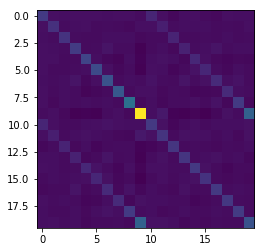

[[ 2.35657597e-01  9.26988784e-02  2.96472485e-01  1.58004072e-01
   2.74798202e-01  2.61543131e-01  3.42501159e-01  3.81260912e-01
   4.62962404e-01  1.21406858e+00  4.62219993e-02  1.88536275e-01
   2.43904976e-01  6.66502252e-02  1.73658187e-01  1.79844940e-01
   2.60549122e-01  2.38003228e-01  2.69499474e-01  6.88942533e-01]
 [-6.80801495e+00 -7.56831721e+00  1.43229906e+01  7.54793976e+00
   1.07320479e+01 -1.07060843e+01  8.85216968e+00  1.70552904e+01
  -9.06366097e+00  1.38785469e+02 -2.38961169e+01  1.31450611e+01
   2.38597544e+01 -2.45206343e+01  1.66597388e+01  8.34781601e+00
   7.13528504e+00 -6.08815012e+00  1.31940852e+00  5.78422604e+01]
 [ 1.06045070e+00  7.96813916e-01  8.78087323e+00  3.71682313e+00
  -2.11572600e+00 -3.59504501e+00 -2.62075768e-01  7.84854605e+00
  -1.89047292e+00  2.65375660e+01 -5.70967944e+00  6.30828001e+00
   4.28914097e+00 -8.81897140e+00 -4.41411246e-01 -4.02588052e+00
   7.21515698e+00  8.09056540e-01 -5.69083064e+00  1.04325894e+01]
 [-2.10

In [9]:
h = np.array(abs(theta_fiducial))*0.01
h[4] = 0.01*0.4

Compressor = score.Gaussian(len(PISNSimulator.data), theta_fiducial, prior_mean=theta_fiducial, prior_covariance=prior_C)
Compressor.compute_mean_covariance(simulator = simulator, nsims = 500)
Compressor.compute_derivatives(simulator = simulator, nsims = 500, h=h)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

plt.imshow(Compressor.C)
plt.show()

print(Compressor.dmudt)

In [10]:

np.sqrt(np.diag(Finv))

array([1.06065679, 0.01557129, 0.05486263, 0.03474654, 0.01736625])

In [11]:
evals, evecs = np.linalg.eigh(Compressor.Finv)

In [12]:
np.sqrt(evals), evecs

(array([0.00880909, 0.01733168, 0.02664585, 0.05652179, 1.06088237]),
 array([[-0.00658679, -0.00131344,  0.01017924, -0.01665398,  0.99978694],
        [-0.91046852, -0.33184666,  0.18446534,  0.16390927, -0.00558209],
        [-0.20524248, -0.0684845 , -0.31585982, -0.92370594, -0.0136129 ],
        [-0.16034727,  0.09747668, -0.92033014,  0.34289816,  0.01415375],
        [-0.32119771,  0.93578002,  0.13818077, -0.04521708, -0.00304684]]))

## Load in the compressed data

In [13]:
compressed_data = compressor(PISNSimulator.data, compressor_args)

## Define ensemble of NDEs

In [14]:
NDEs = [ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=5, n_data=5, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Create DELFI object

In [15]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, 
                            Finv = Finv, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [prior_low, prior_high],
                            param_names = ['h_0', 'Omega_0', 'omega', 'alpha', 'beta'], 
                            results_dir = "results/",
                            input_normalization="fisher")

## Fisher pre-training to initialize the NDEs


Sampling approximate posterior...
Done.


/Users/hyraland/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


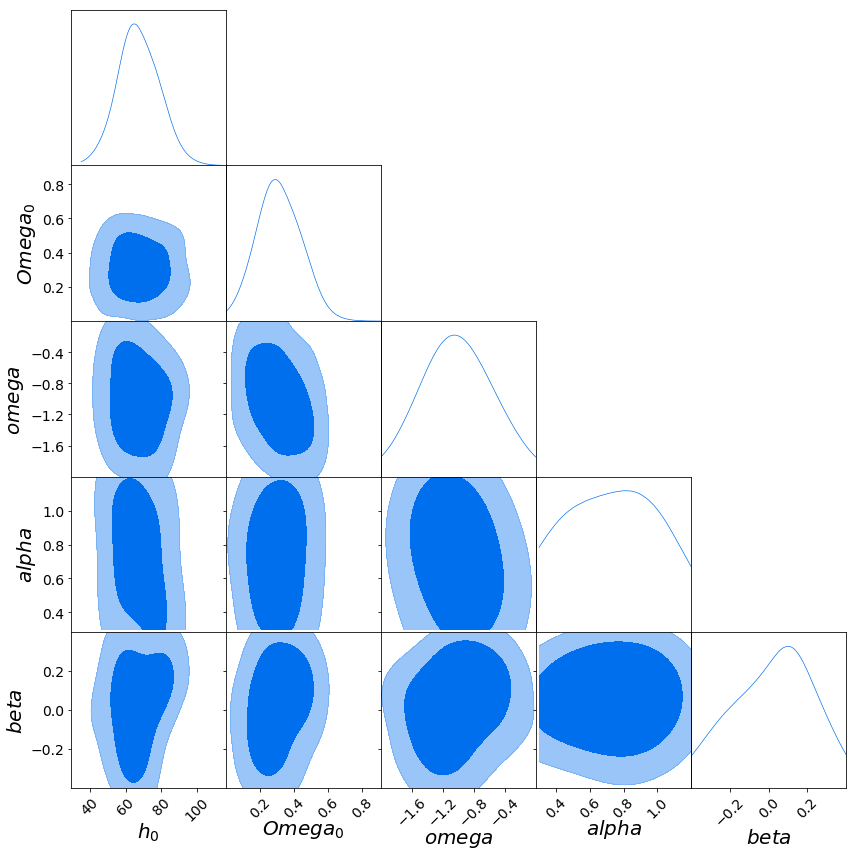

In [16]:
DelfiEnsemble.fisher_pretraining()

## Sequential Neural Likelihood


Population 1/10
Sampling proposal density...
76/|/ 25%|| 76/300 [00:48<03:07,  1.19it/s, train loss=6.4, val loss=7.54, refresh=1]Done.


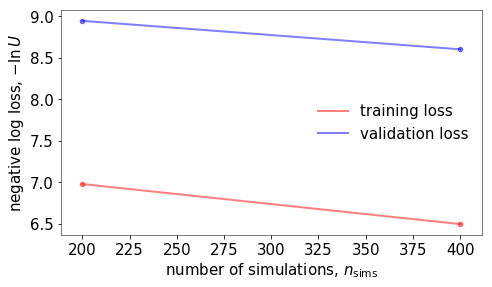

Population 2/10
Sampling proposal density...
72/|/ 24%|| 72/300 [00:48<00:54,  4.18it/s, train loss=5.79, val loss=8.24, refresh=1]Done.


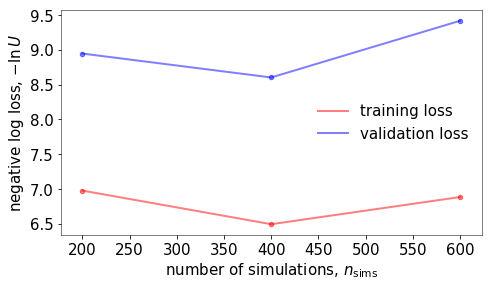

Population 3/10
Sampling proposal density...
65/|/ 22%|| 65/300 [01:38<01:34,  2.49it/s, train loss=6.37, val loss=8.23, refresh=1]Done.


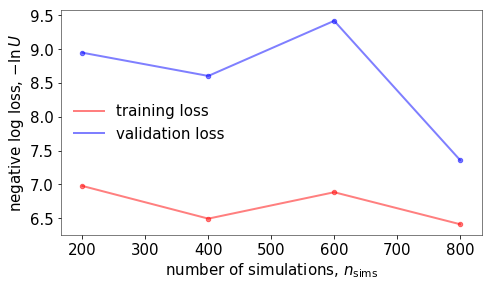

Population 4/10
Sampling proposal density...
59/|/ 20%|| 59/300 [01:58<02:17,  1.75it/s, train loss=6.12, val loss=8.68, refresh=1]Done.


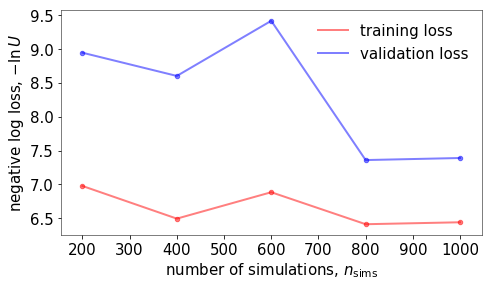

Population 5/10
Sampling proposal density...
55/|/ 18%|| 55/300 [01:31<01:17,  3.17it/s, train loss=5.96, val loss=7.78, refresh=1]Done.


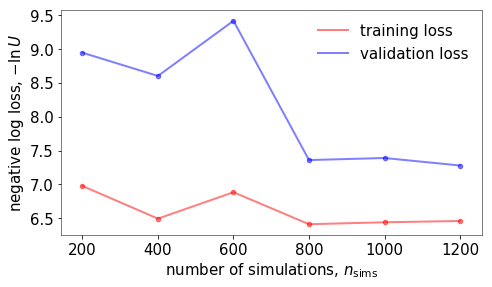

Population 6/10
Sampling proposal density...
50/|/ 17%|| 50/300 [01:26<01:09,  3.59it/s, train loss=6.05, val loss=7.66, refresh=1]Done.


157/|/ 52%|| 157/300 [02:45<00:17,  8.09it/s, train loss=7.72, val loss=9.93, refresh=1]


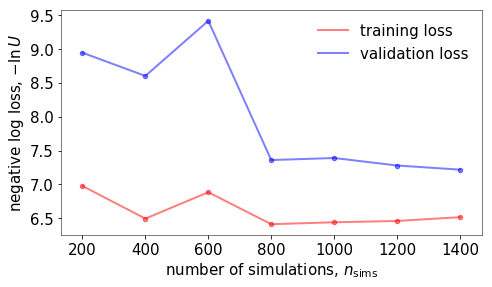

Population 7/10
Sampling proposal density...
51/|/ 17%|| 51/300 [01:40<01:33,  2.66it/s, train loss=6.17, val loss=7.44, refresh=1]Done.


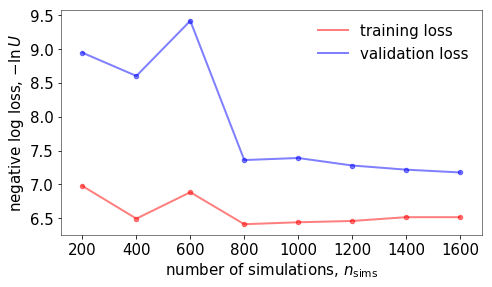

Population 8/10
Sampling proposal density...
56/|/ 19%|| 56/300 [02:04<00:57,  4.26it/s, train loss=6.17, val loss=7.55, refresh=1]Done.


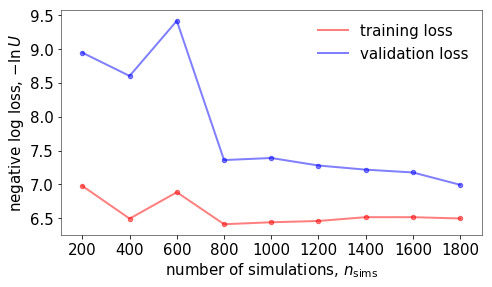

Population 9/10
Sampling proposal density...
44/|/ 15%|| 44/300 [01:20<01:16,  3.34it/s, train loss=6.28, val loss=7.36, refresh=1]Done.


107/|/ 36%|| 107/300 [02:10<00:41,  4.64it/s, train loss=6.4, val loss=6.44, refresh=1]


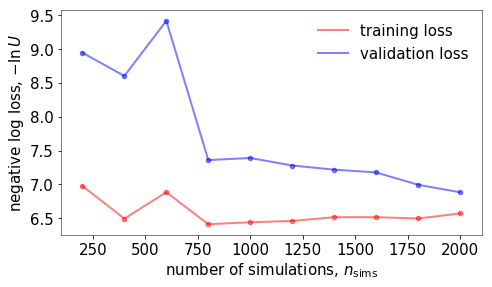

Population 10/10
Sampling proposal density...
23/|/  8%|| 23/300 [00:33<02:12,  2.08it/s, train loss=6.53, val loss=7.25, refresh=1]Done.


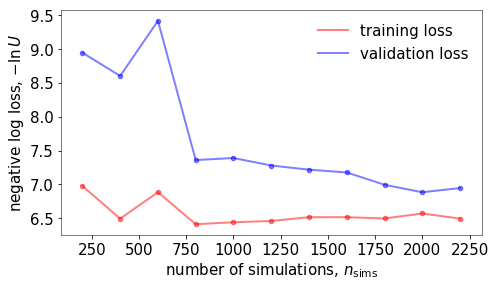

In [17]:
n_initial = 200
n_batch = 200
n_populations = 10

DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20,
                       save_intermediate_posteriors=False)

## Sample the learned posterior

In [18]:
posterior_samples = DelfiEnsemble.emcee_sample()

35/|/ 12%|| 35/300 [01:11<01:12,  3.67it/s, train loss=6.34, val loss=7.47, refresh=1]

/Users/hyraland/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


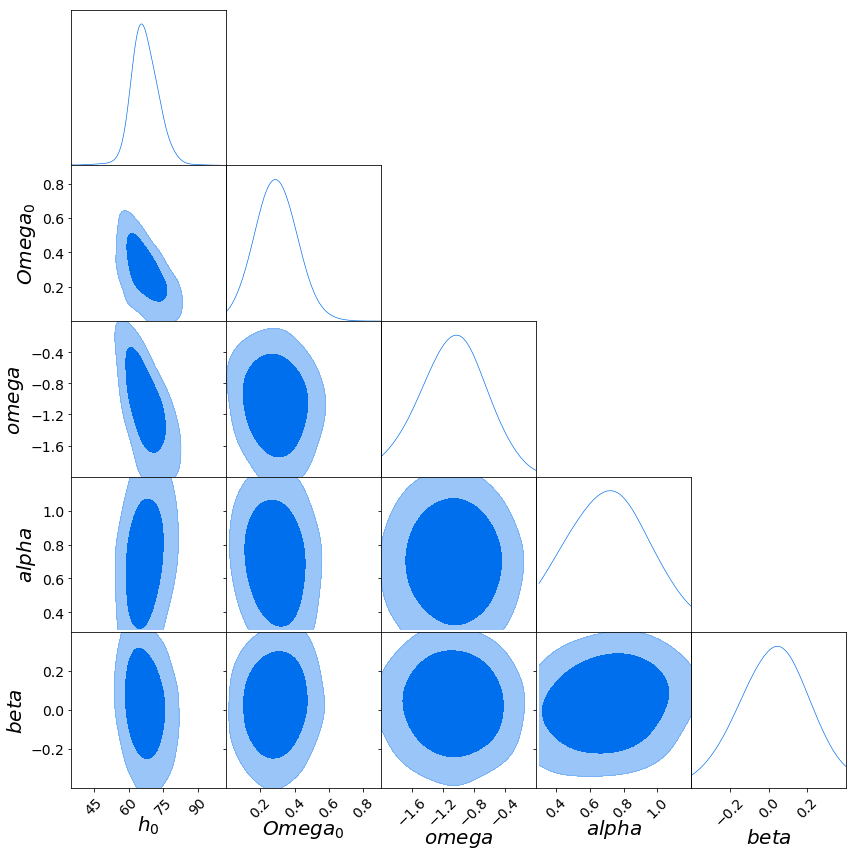

In [19]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples])

In [20]:
print(np.std(posterior_samples, axis=0))
print(np.mean(posterior_samples, axis=0))
print(PISNSimulator.theta_fiducial)

[6.34505988 0.12187164 0.40802302 0.21347641 0.16979915]
[ 6.70903548e+01  2.94135895e-01 -1.06017847e+00  7.19619225e-01
  2.52160497e-02]
[67.74    0.3075 -1.      0.75    0.    ]


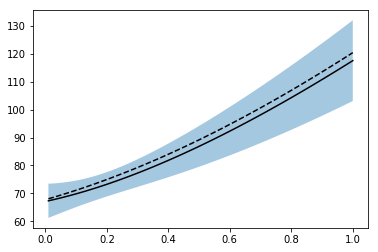

In [21]:
z = np.linspace(0.01,1,50)
Hzs = np.linspace(0,0,50)
Hzs2 = np.linspace(0,0,50)
Hzstd = np.linspace(0,0,50)

for i in posterior_samples:
    cosm = FlatwCDM(i[0],i[1],i[2])
    Hz = cosm.efunc(z)*i[0]
    Hzs += Hz
    Hzs2 += Hz**2
    
    #plt.plot(z,Hz)
Hzs = Hzs/(posterior_samples.shape[0])
Hzs2 = Hzs2/(posterior_samples.shape[0])
Hzstd = np.sqrt(Hzs2-Hzs**2)
#plt.errorbar(z,Hzs, yerr = Hzstd)
plt.plot(z, Planck15.efunc(z)*Planck15.H0.value, 'k--')
plt.plot(z, Hzs, 'k-')
plt.fill_between(z, Hzs-Hzstd, Hzs+Hzstd,alpha = 0.4)
plt.show()

In [22]:
minind = np.where(Hzstd == min(Hzstd))[0][0]
print(Hzstd[minind],z[minind])
print(Hzstd[minind]/Hzs[minind])

4.361523733988827 0.19183673469387755
0.05978897931696398
